In [9]:
from copy import copy
from types import MappingProxyType
from typing import (
    Any,
    List,
    Tuple,
    Union,
    Mapping,
    Callable,
    Optional,
    Sequence,
    TYPE_CHECKING,
)
from inspect import signature
from pathlib import Path
from functools import wraps
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
import pandas as pd
from scanpy import logging as logg, settings
from anndata import AnnData
from matplotlib.figure import Figure
import seaborn as sns

In [43]:





class PySankeyException(Exception):
    pass


class NullsInFrame(PySankeyException):
    pass


class LabelMismatch(PySankeyException):
    pass


def check_data_matches_labels(labels, data, side):
    if len(labels > 0):
        if isinstance(data, list):
            data = set(data)
        if isinstance(data, pd.Series):
            data = set(data.unique().tolist())
        if isinstance(labels, list):
            labels = set(labels)
        if labels != data:
            msg = "\n"
            if len(labels) <= 20:
                msg = "Labels: " + ",".join(labels) + "\n"
            if len(data) < 20:
                msg += "Data: " + ",".join(data)
            raise LabelMismatch('{0} labels and data do not match.{1}'.format(side, msg))


def sankey(left, right, leftWeight=None, rightWeight=None, colorDict=None,
           leftLabels=None, rightLabels=None, aspect=4, rightColor=False,
           fontsize=14, figureName=None, closePlot=False):
    '''
    Make Sankey Diagram showing flow from left-->right
    Inputs:
        left = NumPy array of object labels on the left of the diagram
        right = NumPy array of corresponding labels on the right of the diagram
            len(right) == len(left)
        leftWeight = NumPy array of weights for each strip starting from the
            left of the diagram, if not specified 1 is assigned
        rightWeight = NumPy array of weights for each strip starting from the
            right of the diagram, if not specified the corresponding leftWeight
            is assigned
        colorDict = Dictionary of colors to use for each label
            {'label':'color'}
        leftLabels = order of the left labels in the diagram
        rightLabels = order of the right labels in the diagram
        aspect = vertical extent of the diagram in units of horizontal extent
        rightColor = If true, each strip in the diagram will be be colored
                    according to its left label
    Ouput:
        None
    '''
    if leftWeight is None:
        leftWeight = []
    if rightWeight is None:
        rightWeight = []
    if leftLabels is None:
        leftLabels = []
    if rightLabels is None:
        rightLabels = []
    # Check weights
    if len(leftWeight) == 0:
        leftWeight = np.ones(len(left))

    if len(rightWeight) == 0:
        rightWeight = leftWeight

    plt.figure()
    plt.rc('text', usetex=False)
    plt.rc('font', family='serif')

    # Create Dataframe
    if isinstance(left, pd.Series):
        left = left.reset_index(drop=True)
    if isinstance(right, pd.Series):
        right = right.reset_index(drop=True)
    dataFrame = pd.DataFrame({'left': left, 'right': right, 'leftWeight': leftWeight,
                              'rightWeight': rightWeight}, index=range(len(left)))

    if len(dataFrame[(dataFrame.left.isnull()) | (dataFrame.right.isnull())]):
        raise NullsInFrame('Sankey graph does not support null values.')

    # Identify all labels that appear 'left' or 'right'
    allLabels = pd.Series(np.r_[dataFrame.left.unique(), dataFrame.right.unique()]).unique()

    # Identify left labels
    if len(leftLabels) == 0:
        leftLabels = pd.Series(dataFrame.left.unique()).unique()
    else:
        check_data_matches_labels(leftLabels, dataFrame['left'], 'left')

    # Identify right labels
    if len(rightLabels) == 0:
        rightLabels = pd.Series(dataFrame.right.unique()).unique()
    else:
        check_data_matches_labels(leftLabels, dataFrame['right'], 'right')
    # If no colorDict given, make one
    if colorDict is None:
        colorDict = {}
        palette = "hls"
        colorPalette = sns.color_palette(palette, len(allLabels))
        for i, label in enumerate(allLabels):
            colorDict[label] = colorPalette[i]
    else:
        missing = [label for label in allLabels if label not in colorDict.keys()]
        if missing:
            msg = "The colorDict parameter is missing values for the following labels : "
            msg += '{}'.format(', '.join(missing))
            raise ValueError(msg)
            
    print(dataFrame)

    # Determine widths of individual strips
    ns_l = defaultdict()
    ns_r = defaultdict()
    for leftLabel in leftLabels:
        leftDict = {}
        rightDict = {}
        for rightLabel in rightLabels:
            leftDict[rightLabel] = dataFrame[(dataFrame.left == leftLabel) & (dataFrame.right == rightLabel)].leftWeight.sum()
            rightDict[rightLabel] = dataFrame[(dataFrame.left == leftLabel) & (dataFrame.right == rightLabel)].rightWeight.sum()
        ns_l[leftLabel] = leftDict
        ns_r[leftLabel] = rightDict
        
    print("ns_l is ", ns_l)
    print("ns_r is ", ns_r)

    # Determine positions of left label patches and total widths
    leftWidths = defaultdict()
    for i, leftLabel in enumerate(leftLabels):
        myD = {}
        myD['left'] = dataFrame[dataFrame.left == leftLabel].leftWeight.sum()
        if i == 0:
            myD['bottom'] = 0
            myD['top'] = myD['left']
        else:
            myD['bottom'] = leftWidths[leftLabels[i - 1]]['top'] + 0.02 * dataFrame.leftWeight.sum()
            myD['top'] = myD['bottom'] + myD['left']
            topEdge = myD['top']
        leftWidths[leftLabel] = myD

    # Determine positions of right label patches and total widths
    rightWidths = defaultdict()
    for i, rightLabel in enumerate(rightLabels):
        myD = {}
        myD['right'] = dataFrame[dataFrame.right == rightLabel].rightWeight.sum()
        if i == 0:
            myD['bottom'] = 0
            myD['top'] = myD['right']
        else:
            myD['bottom'] = rightWidths[rightLabels[i - 1]]['top'] + 0.02 * dataFrame.rightWeight.sum()
            myD['top'] = myD['bottom'] + myD['right']
            topEdge = myD['top']
        rightWidths[rightLabel] = myD

    # Total vertical extent of diagram
    xMax = topEdge / aspect

    # Draw vertical bars on left and right of each  label's section & print label
    for leftLabel in leftLabels:
        plt.fill_between(
            [-0.02 * xMax, 0],
            2 * [leftWidths[leftLabel]['bottom']],
            2 * [leftWidths[leftLabel]['bottom'] + leftWidths[leftLabel]['left']],
            color=colorDict[leftLabel],
            alpha=0.99
        )
        plt.text(
            -0.05 * xMax,
            leftWidths[leftLabel]['bottom'] + 0.5 * leftWidths[leftLabel]['left'],
            leftLabel,
            {'ha': 'right', 'va': 'center'},
            fontsize=fontsize
        )
    for rightLabel in rightLabels:
        plt.fill_between(
            [xMax, 1.02 * xMax], 2 * [rightWidths[rightLabel]['bottom']],
            2 * [rightWidths[rightLabel]['bottom'] + rightWidths[rightLabel]['right']],
            color=colorDict[rightLabel],
            alpha=0.99
        )
        plt.text(
            1.05 * xMax,
            rightWidths[rightLabel]['bottom'] + 0.5 * rightWidths[rightLabel]['right'],
            rightLabel,
            {'ha': 'left', 'va': 'center'},
            fontsize=fontsize
        )

    # Plot strips
    for leftLabel in leftLabels:
        for rightLabel in rightLabels:
            labelColor = leftLabel
            if ind==0:
                labelColor = rightLabel
            if len(dataFrame[(dataFrame.left == leftLabel) & (dataFrame.right == rightLabel)]) > 0:
                # Create array of y values for each strip, half at left value,
                # half at right, convolve
                ys_d = np.array(50 * [leftWidths[leftLabel]['bottom']] + 50 * [rightWidths[rightLabel]['bottom']])
                ys_d = np.convolve(ys_d, 0.05 * np.ones(20), mode='valid')
                ys_d = np.convolve(ys_d, 0.05 * np.ones(20), mode='valid')
                ys_u = np.array(50 * [leftWidths[leftLabel]['bottom'] + ns_l[leftLabel][rightLabel]] + 50 * [rightWidths[rightLabel]['bottom'] + ns_r[leftLabel][rightLabel]])
                ys_u = np.convolve(ys_u, 0.05 * np.ones(20), mode='valid')
                ys_u = np.convolve(ys_u, 0.05 * np.ones(20), mode='valid')

                # Update bottom edges at each label so next strip starts at the right place
                leftWidths[leftLabel]['bottom'] += ns_l[leftLabel][rightLabel]
                rightWidths[rightLabel]['bottom'] += ns_r[leftLabel][rightLabel]
                plt.fill_between(
                    np.linspace(0, xMax, len(ys_d)), ys_d, ys_u, alpha=0.65,
                    color=colorDict[labelColor]
                )
    plt.gca().axis('off')
    plt.gcf().set_size_inches(6, 6)
    if figureName != None:
        plt.savefig("{}.png".format(figureName), bbox_inches='tight', dpi=150)
    if closePlot:
        plt.close()

In [61]:
colorDict=None
leftLabels=None
rightLabels=None 
aspect=4
rightColor=False
fontsize=14
figureName=None 
closePlot=False

In [14]:
left = ["cat1", 'cat2', 'cat_3']
right = ["1cat", '2cat', '3cat']


In [16]:
df = pd.DataFrame(np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]]),
                   columns=['a', 'b', 'c'])

In [18]:
import itertools

In [26]:
[[i,j] for i, j in itertools.product(left, right)]

[['cat1', '1cat'],
 ['cat1', '2cat'],
 ['cat1', '3cat'],
 ['cat2', '1cat'],
 ['cat2', '2cat'],
 ['cat2', '3cat'],
 ['cat_3', '1cat'],
 ['cat_3', '2cat'],
 ['cat_3', '3cat']]

In [19]:
list(itertools.combinations(range(6), 2))

[(0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (0, 5),
 (1, 2),
 (1, 3),
 (1, 4),
 (1, 5),
 (2, 3),
 (2, 4),
 (2, 5),
 (3, 4),
 (3, 5),
 (4, 5)]

In [29]:
df = pd.DataFrame([[i,j] for i, j in itertools.product(left, right)], columns=["source", "target"])

In [35]:
df["value"] = np.abs(np.random.randn(len(df)))

In [36]:
df

,source,target,value
0,cat1,1cat,0.705131
1,cat1,2cat,0.019469
2,cat1,3cat,0.601573
3,cat2,1cat,1.297453
4,cat2,2cat,0.441339
5,cat2,3cat,2.507311
6,cat_3,1cat,0.449477
7,cat_3,2cat,1.446802
8,cat_3,3cat,1.403496


    left right  leftWeight  rightWeight
0   cat1  1cat         1.0          1.0
1   cat2  2cat         1.0          1.0
2  cat_3  3cat         1.0          1.0
ns_l is  defaultdict(None, {'cat1': {'1cat': 1.0, '2cat': 0.0, '3cat': 0.0}, 'cat2': {'1cat': 0.0, '2cat': 1.0, '3cat': 0.0}, 'cat_3': {'1cat': 0.0, '2cat': 0.0, '3cat': 1.0}})
ns_r is  defaultdict(None, {'cat1': {'1cat': 1.0, '2cat': 0.0, '3cat': 0.0}, 'cat2': {'1cat': 0.0, '2cat': 1.0, '3cat': 0.0}, 'cat_3': {'1cat': 0.0, '2cat': 0.0, '3cat': 1.0}})


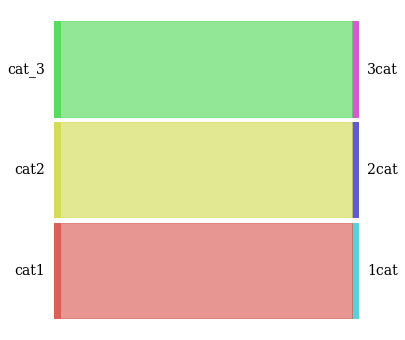

In [44]:
sankey(left, right)

In [64]:
leftLabels = df["source"].unique()
rightLabels = df["target"].unique()

In [63]:
leftLabels

In [47]:
df

,source,target,value
0,cat1,1cat,0.705131
1,cat1,2cat,0.019469
2,cat1,3cat,0.601573
3,cat2,1cat,1.297453
4,cat2,2cat,0.441339
5,cat2,3cat,2.507311
6,cat_3,1cat,0.449477
7,cat_3,2cat,1.446802
8,cat_3,3cat,1.403496


In [49]:
dff = df.pivot(index='source', columns='target', values='value')


In [52]:
dff

target,1cat,2cat,3cat
source,,,
cat1,0.705131,0.019469,0.601573
cat2,1.297453,0.441339,2.507311
cat_3,0.449477,1.446802,1.403496


In [74]:
dff2 = dff.T

In [76]:
dff2

source,cat1,cat2,cat_3
target,,,
1cat,0.705131,1.297453,0.449477
2cat,0.019469,0.441339,1.446802
3cat,0.601573,2.507311,1.403496


In [55]:
dataFrame = dff

In [67]:
allLabels = set(leftLabels).union(set(rightLabels))

In [68]:
allLabels

{'1cat', '2cat', '3cat', 'cat1', 'cat2', 'cat_3'}

In [71]:
colorDict = None

defaultdict(None, {'cat1': {'left': 1.3261731582060783, 'bottom': 0, 'top': 1.3261731582060783}, 'cat2': {'left': 4.246103443798698, 'bottom': 1.5036141922556436, 'top': 5.749717636054342}, 'cat_3': {'left': 3.299775100473485, 'bottom': 5.927158670103907, 'top': 9.226933770577393}})
defaultdict(None, {'1cat': {'left': 2.4520612653649367, 'bottom': 0, 'top': 2.4520612653649367}, '2cat': {'left': 1.9076102133573634, 'bottom': 2.629502299414502, 'top': 4.5371125127718654}, '3cat': {'left': 4.512380223755962, 'bottom': 4.71455354682143, 'top': 9.226933770577393}})


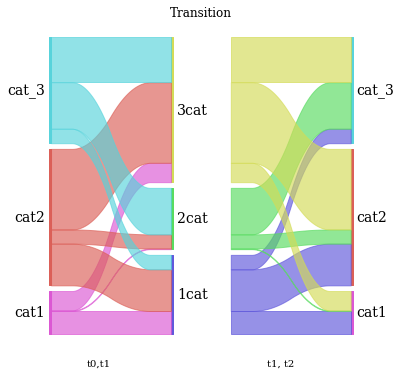

In [170]:
"""ns_l = defaultdict()
ns_r = defaultdict()
for leftLabel in leftLabels:
    leftDict = {}
    rightDict = {}
    for rightLabel in rightLabels:
        leftDict[rightLabel] = dataFrame[(dataFrame.left == leftLabel) & (dataFrame.right == rightLabel)].leftWeight.sum()
        rightDict[rightLabel] = dataFrame[(dataFrame.left == leftLabel) & (dataFrame.right == rightLabel)].rightWeight.sum()
    ns_l[leftLabel] = leftDict
    ns_r[leftLabel] = rightDict"""

titles = ["t0,t1", "t1, t2"]

if colorDict is None:
    colorDict = {}
    palette = "hls"
    colorPalette = sns.color_palette(palette, len(allLabels))
    for i, label in enumerate(allLabels):
        colorDict[label] = colorPalette[i]
else:
    missing = [label for label in allLabels if label not in colorDict.keys()]
    if missing:
        msg = "The colorDict parameter is missing values for the following labels : "
        msg += '{}'.format(', '.join(missing))
        raise ValueError(msg)

left_pos = [0]
for ind, dataFrame in enumerate([dff, dff2]):

    leftLabels = list(dataFrame.index)
    rightLabels = list(dataFrame.columns)
    allLabels = set(leftLabels).union(set(rightLabels))
    
    # Determine positions of left label patches and total widths
    leftWidths = defaultdict()
    for i, leftLabel in enumerate(leftLabels):
        myD = {}
        myD['left'] = dataFrame.loc[leftLabel,:].sum()
        if i == 0:
            myD['bottom'] = 0
            myD['top'] = myD['left']
        else:
            myD['bottom'] = leftWidths[leftLabels[i - 1]]['top'] + 0.02 * dataFrame.sum().sum()
            myD['top'] = myD['bottom'] + myD['left']
            topEdge = myD['top']
        leftWidths[leftLabel] = myD

    # Determine positions of right label patches and total widths
    rightWidths = defaultdict()
    for i, rightLabel in enumerate(rightLabels):
        myD = {}
        myD['right'] = dataFrame.loc[:, rightLabel].sum()
        if i == 0:
            myD['bottom'] = 0
            myD['top'] = myD['right']
        else:
            myD['bottom'] = rightWidths[rightLabels[i - 1]]['top'] + 0.02 * dataFrame.sum().sum()
            myD['top'] = myD['bottom'] + myD['right']
            topEdge = myD['top']
        rightWidths[rightLabel] = myD

    # Total vertical extent of diagram
    xMax = topEdge / aspect

    # Draw vertical bars on left and right of each  label's section & print label
    for leftLabel in leftLabels:
        if ind==0:
            plt.fill_between(
                [-0.02 * xMax, 0],
                2 * [leftWidths[leftLabel]['bottom']],
                2 * [leftWidths[leftLabel]['bottom'] + leftWidths[leftLabel]['left']],
                color=colorDict[leftLabel],
                alpha=0.99
            )
            plt.text(
                -0.05 * xMax,
                leftWidths[leftLabel]['bottom'] + 0.5 * leftWidths[leftLabel]['left'],
                leftLabel,
                {'ha': 'right', 'va': 'center'},
                fontsize=fontsize
            )
    for rightLabel in rightLabels:
        plt.fill_between(
            [xMax+ left_pos[ind] , 1.02 * xMax+ left_pos[ind] ], 2 * [rightWidths[rightLabel]['bottom']],
            2 * [rightWidths[rightLabel]['bottom'] + rightWidths[rightLabel]['right']],
            color=colorDict[rightLabel],
            alpha=0.99
        )
        plt.text(
            1.05 * xMax + left_pos[ind],
            rightWidths[rightLabel]['bottom'] + 0.5 * rightWidths[rightLabel]['right'],
            rightLabel,
            {'ha': 'left', 'va': 'center'},
            fontsize=fontsize
        )
    print(leftWidths)
    y_max = np.min([leftWidths[cat]["bottom"] for cat in leftWidths.keys()])

    plt.text(left_pos[ind]+ 0.3*xMax, -1, titles[ind])
        
    left_pos += [1.5*xMax]

    # Plot strips
    for leftLabel in leftLabels:
        for rightLabel in rightLabels:
            labelColor = leftLabel
            if rightColor:
                if ind==0:
                    labelColor = leftLabel
                else:
                    labelColor = leftLabel
            if dataFrame.loc[leftLabel, rightLabel] > 0:
                # Create array of y values for each strip, half at left value,
                # half at right, convolve
                ys_d = np.array(50 * [leftWidths[leftLabel]['bottom']] + 50 * [rightWidths[rightLabel]['bottom']])
                ys_d = np.convolve(ys_d, 0.05 * np.ones(20), mode='valid')
                ys_d = np.convolve(ys_d, 0.05 * np.ones(20), mode='valid')
                ys_u = np.array(50 * [leftWidths[leftLabel]['bottom'] + dataFrame.loc[leftLabel, rightLabel]] + 50 * [rightWidths[rightLabel]['bottom'] + dataFrame.loc[leftLabel, rightLabel]])
                ys_u = np.convolve(ys_u, 0.05 * np.ones(20), mode='valid')
                ys_u = np.convolve(ys_u, 0.05 * np.ones(20), mode='valid')

                # Update bottom edges at each label so next strip starts at the right place
                leftWidths[leftLabel]['bottom'] += dataFrame.loc[leftLabel, rightLabel]
                rightWidths[rightLabel]['bottom'] += dataFrame.loc[leftLabel, rightLabel]

                if ind==0:
                    plt.fill_between(
                        np.linspace(0+left_pos[ind], xMax+left_pos[ind], len(ys_d)), ys_d, ys_u, alpha=0.65,
                        color=colorDict[labelColor]
                    )
                else:
                    plt.fill_between(
                    np.linspace(0+left_pos[ind], xMax+left_pos[ind], len(ys_d)), ys_d, ys_u, alpha=0.65,
                    color=colorDict[labelColor]
                )
    
    plt.gca().axis('off')
    plt.gcf().set_size_inches(6, 6)
    plt.title("Transition")
    #if figureName != None:
    #    plt.savefig("{}.png".format(figureName), bbox_inches='tight', dpi=150)
    #if closePlot:
    #    plt.close()

9.226933770577391

In [151]:
rightWidths

defaultdict(None,
            {'cat1': {'right': 1.3261731582060783,
              'bottom': 1.3261731582060783,
              'top': 1.3261731582060783},
             'cat2': {'right': 4.246103443798698,
              'bottom': 5.749717636054342,
              'top': 5.749717636054342},
             'cat_3': {'right': 3.299775100473485,
              'bottom': 9.226933770577393,
              'top': 9.226933770577393}})

In [82]:
leftWidths

defaultdict(None, {})